# Semi-Supervised Architope (Chaotic Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters
In Grid_Enhanced_NetworkGrid_Enhanced_Network.py file

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 9

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid - here is set the Option_Function
exec(open('Grid_Enhanced_Network.py').read()) 
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Chaos_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
ks input data             0         1         2         3         4         5         6  \
0    0.125730 -0.132105  0.640423  0.104900 -0.535669  0.361595  1.304000   
1    0.216882  0.226767  0.206371  0.167188  0.095333  0.007688 -0.103964   
2    0.162985  0.149990  0.112828  0.065765 -0.003181 -0.076505 -0.163321   
3    0.114432  0.092607  0.051743  0.006617 -0.054806 -0.115655 -0.186224   
4    0.079127  0.052647  0.010571 -0.032159 -0.087764 -0.139907 -0.199704   
..        ...       ...       ...       ...       ...       ...       ...   
993  7.059567  5.393529  3.464303  1.401718 -0.676549 -2.624797 -4.340786   
994  7.501198  5.928769  4.059124  2.014938 -0.088556 -2.102837 -3.918068   
995  7.894172  6.419470  4.617361  2.602546  0.486503 -1.580957 -3.483852   
996  8.239988  6.865526  5.137275  3.161374  1.044443 -1.063830 -3.042747   
997  8.540795  7.267648  5.618023  3.689128  1.581829 -0.555574 -2.599042   

        

In [6]:
print(Option_Function)

ks


### Set Seed

In [7]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [8]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [9]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    # note this operation:',distance_matrix(X_train_in_shuffled,X_train_in_shuffled).shape)
    print('size of Data driven radius:',Delta_X.shape)
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print('pool train loop percentage:',(N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                #y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
                y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [10]:
import time
partitioning_time_begin = time.time()

In [11]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    if Option_Function == 'ks':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5 #.3
        min_size_part = 30 #7000
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [12]:
print(type(X_train),type(data_y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [13]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regenerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size=min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts in the input are: ' + str(len(X_parts_list))+'.')
    print('X_parts_list:', X_parts_list)
    print('The_parts_listhe number of parts in the output are: ' + str(len(y_parts_list))+'.')
    print('y_parts_list:', y_parts_list)
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

size of Data driven radius: (898,)
pool train loop percentage: 0.9220489977728286
pool train loop percentage: 0.8942093541202673
pool train loop percentage: 0.8752783964365256
pool train loop percentage: 0.856347438752784
pool train loop percentage: 0.8396436525612472
pool train loop percentage: 0.8251670378619154
pool train loop percentage: 0.811804008908686
pool train loop percentage: 0.7984409799554566
pool train loop percentage: 0.7850779510022272
pool train loop percentage: 0.7739420935412027
pool train loop percentage: 0.7628062360801782
pool train loop percentage: 0.7494432071269488
pool train loop percentage: 0.7371937639198218
pool train loop percentage: 0.7249443207126949
pool train loop percentage: 0.7115812917594655
pool train loop percentage: 0.6993318485523385
pool train loop percentage: 0.6870824053452116
pool train loop percentage: 0.6714922048997772
pool train loop percentage: 0.6570155902004454
pool train loop percentage: 0.643652561247216
pool train loop percentage: 

In [14]:
#Iteration_Length = len(X_parts_list)
#N_modify = []
#for jj in range(Iteration_Length):
 #   N_modify = np.append(N_modify,(len(X_parts_list[jj])))
    
#print(N_modify)

In [15]:
partitioning_time = time.time() - partitioning_time_begin

In [16]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 2.


#### Building Training Predictions on each part (each part represent a different manifold)
- Train locally (on each "naive part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [17]:
# Time-Elapse (Start) for Training on Each Part
Architope_partition_training_begin = time.time()
# Initialize running max for Parallel time
Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
# Initialize N_parameter counter for Architope
N_params_Architope = 0

[0.078125 0.921875]
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 0 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 70)
X2 shape: (2048, 70)
s: [4.92328957e+02 9.30826811e+01 4.40645441e+01 2.60559926e+01
 9.76826501e+00 4.95078113e+00 2.37770823e+00 9.91084386e-01
 4.97454930e-01 2.03835549e-01 9.23568373e-02 3.94712171e-02
 1.54306815e-02 6.81090251e-03 2.72918361e-03 1.20626568e-03
 4.23802398e-04 1.76833537e-04 6.74731152e-05 2.73839550e-05
 9.38160000e-06 3.72706083e-06 1.30804174e-06 4.82642880e-07
 1.66520942e-07 6.32758135e-08 2.13249978e-08 7.35444992e-09
 2.49045002e-09 8.27338911e-10 2.72407958e-10 9.48964399e-11
 2.84983994e-11 9.30576037e-12 2.96991476e-12 8.32739475e-13
 2.77368414e-13 8.70773219e-14 5.24928522e-14 4.74872867e-14
 4.74872867e-14 4.74872867e-14 4.74872867e-14 4.74872867e-14
 4.74872867e-14 4.74872867e-14 4.74872867e-14 4.74872867e-14
 4.74872867e-14 4.74872867e-14 4.74872867

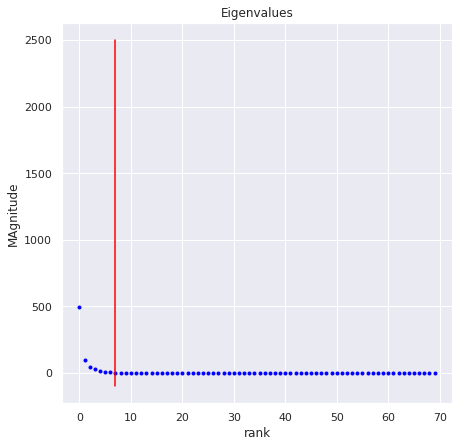

omega: [-555.72121914+0.j          -54.45498041+0.j
    6.56969573+6.53106508j    6.56969573-6.53106508j
    3.33294399+0.j            1.65112462+0.j
   -9.82993524+0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
b shape: (7, 1)
omega shape: (7,)
time_dynamics shape: (898, 7)
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (898, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 826)
X2 shape: (2048, 826)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


s: [2.50296572e+03 2.39792635e+03 2.22251969e+03 2.04974672e+03
 2.02295577e+03 1.88866284e+03 1.80248300e+03 1.62001774e+03
 1.47091706e+03 1.42480616e+03 1.33435731e+03 1.28371291e+03
 1.23518757e+03 1.16595662e+03 1.13713736e+03 1.08720955e+03
 1.00531091e+03 9.17468112e+02 8.79671664e+02 8.27052926e+02
 7.61563172e+02 7.42932136e+02 7.16303997e+02 6.66968657e+02
 6.39889550e+02 6.27099050e+02 5.43013657e+02 5.25959973e+02
 4.99539177e+02 4.84601242e+02 4.52451276e+02 4.36813104e+02
 3.94636911e+02 3.75361812e+02 3.61067640e+02 3.43833744e+02
 3.37230053e+02 2.96029521e+02 2.55872891e+02 2.40914605e+02
 2.36138461e+02 2.29828064e+02 1.86450939e+02 1.84324582e+02
 1.77736215e+02 1.65129646e+02 1.50072758e+02 1.39030569e+02
 1.33533713e+02 1.21228160e+02 1.12234510e+02 1.07385599e+02
 1.03622830e+02 9.71536267e+01 9.55966293e+01 9.09140339e+01
 8.35238464e+01 7.94569453e+01 7.53236822e+01 7.14412827e+01
 6.67779858e+01 6.42682154e+01 6.02101652e+01 5.71612180e+01
 5.50231705e+01 5.177

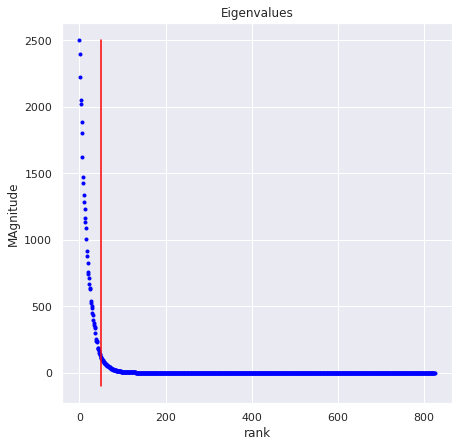

omega: [-0.15493952+18.21488709j -0.15493952-18.21488709j
 -0.05521492+16.71732686j -0.05521492-16.71732686j
 -0.02366995+16.00290595j -0.02366995-16.00290595j
 -0.12521356+15.27783982j -0.12521356-15.27783982j
 -0.03395625+14.40688919j -0.03395625-14.40688919j
 -0.32958616+14.40535179j -0.32958616-14.40535179j
 -0.01111322+13.28305591j -0.01111322-13.28305591j
  0.03211096+12.7529933j   0.03211096-12.7529933j
  0.04351367+11.8469331j   0.04351367-11.8469331j
  0.19153712+11.09895939j  0.19153712-11.09895939j
  0.11265602+10.43727481j  0.11265602-10.43727481j
  0.13152693 +9.54547362j  0.13152693 -9.54547362j
  0.18456509 +8.99948729j  0.18456509 -8.99948729j
  0.18136991 +8.1735861j   0.18136991 -8.1735861j
  0.17156425 +7.51748923j  0.17156425 -7.51748923j
  0.04059325 +6.80348389j  0.04059325 -6.80348389j
  0.03570007 +5.9855864j   0.03570007 -5.9855864j
  0.00706835 +5.40742073j  0.00706835 -5.40742073j
  0.04750322 +4.69904168j  0.04750322 -4.69904168j
  0.10178022 +3.94314394j  0

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [18]:
tf.compat.v1.disable_eager_execution()
# Silly Coercsion for ICML rebuttle deadline timeline
if Option_Function == 'Motivational_Example':
    Iteration_Length = len(X_parts_list) -1
else:
    Iteration_Length = len(X_parts_list)

N_modify0 = []
for kk in range(Iteration_Length):
    N_modify0 = np.append(N_modify0,(len(X_parts_list[kk])))
    
N_modify_tot = sum(N_modify0)

N_modify = []
for jj in range(Iteration_Length):
    N_modify = np.append(N_modify,(len(X_parts_list[jj])/N_modify_tot))

print(N_modify)
    
# Train each part!
for current_part in range(Iteration_Length):
    #==============#
    # Timer(begin) #
    #==============#
    current_part_training_time_for_parallel_begin = time.time()
    
    Iteration_Length = len(X_parts_list)
    
    
    # Initializations #
    #-----------------#
    # Reload Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Modify heights according to optimal (data-driven) rule (with threshold)
    ## current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
    ## print('N_ratios',N_ratios,'Iteration_Length',Iteration_Length)
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################
    # Modify heights of the ANN in order to make it more interpretable for our approach
    current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height']))#*N_modify[current_part])
    ##################################################################################################
    ##################################################################################################
    current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
    current_height = np.maximum(current_height,current_height_threshold)
    current_height = current_height.astype(int).tolist()
    # current_height = X_parts_list.shape[curerent_part,row]
    param_grid_Vanilla_Nets['height'] = current_height
    # Automatically Fix Input Dimension
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
    param_grid_Vanilla_Nets['output_dim'] = [X_train.shape[1]]
    print('param_grid_Vanilla_Nets - input dim:',param_grid_Vanilla_Nets['input_dim'])
    print('param_grid_Vanilla_Nets - output dim:',param_grid_Vanilla_Nets['output_dim'])
    
    # Update User #
    #-------------#
    print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
    print('Heights to iterate over: '+str(current_height))
    
    # Generate Prediction(s) on current Part #
    #----------------------------------------#
    # Failsafe (number of data-points)
    CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
    # Train Network
    #y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                      #n_jobs = n_jobs,
                                                                                      #n_iter = n_iter, 
                                                                                      #param_grid_in = param_grid_Vanilla_Nets, 
                                                                                      #X_train= X_parts_list[current_part], 
                                                                                      #y_train=y_parts_list[current_part],
                                                                                      #X_test_partial=X_train,
                                                                                      #X_test=X_test,
                                                                                      #NOCV=True)
    # DMD (Dynamic Mode Decomposition)
    # Here we apply the DMD algorithm
    ######################################################
    ######################################################
    ######################################################
    # get two views of the data matrix offset by one time step
    #X1 = np.matrix(X[:, 0:-2]) #augmented input data state space
    #X2 = np.matrix(X[:, 1:-1]) #augmented output data state space
    X1 = np.matrix(X_parts_list[current_part]).T #augmented input data state space
    X2 = np.matrix(y_parts_list[current_part]).T #augmented input data state space
    ############ -- augment data -- ##########
    ############# -- with dealy -- ###########
    print('X1 shape:',X1.shape)
    print('X2 shape:',X2.shape)
    #N_augment = 10000
    #idx_x = np.linspace(1, N_augment, num=N_augment, endpoint=True)
    #idx_x = np.matrix(idx_x)
    #print(idx_x.shape)
    #for ii in range(500):
        #idx_x = np.concatenate([idx_x, (idx_x[-1,:]+(np.ones((N_augment,), dtype=int).T))],axis=0)
    #print(idx_x.shape)
    #print(idx_x)
    #start_idx = int(np.min(idx_x[1,:]))
    #end_idx = int(np.max(idx_x[1,:]))
    #X1__ = X1[:,start_idx:end_idx]
    #X2__ = X2[:,start_idx:end_idx]
    #print(X1__.shape)
    #for jj in range(500):
        #start_idx = int(np.min(idx_x[1,:]))
        #end_idx = int(np.max(idx_x[1,:]))
        #X1__ = np.concatenate([X1__, X1[:,start_idx:end_idx]],axis=0)
        #X2__ = np.concatenate([X2__, X2[:,start_idx:end_idx]],axis=0)
    #print(X1__.shape)
    #print(X2__.shape)
    ##########################################
    ##########################################
    # Run SVD on the data view of X1
    U,s,Vh = np.linalg.svd(X1)
    print('s:',s)
    V = Vh.conj().T
    S = np.matrix(np.diag(s))
    
    ##########################################
    ##########################################
    fig = plt.figure(figsize=(7,7))
    # Creating subplot/axes
    ax = fig.add_subplot(111)
    
    # Setting axes/plot title
    ax.set_title('Eigenvalues')
    
    # Setting X-axis and Y-axis limits
    #ax.set_xlim([0.5, 4.5])
    #ax.set_ylim([-3, 7])
    if current_part == 0:
        r = 7 #rank truncation
    else:
        r = 50 #rank truncation
    
    ax.plot(s,'.', color='blue')
    ax.plot([r, r], [-100, 2500], color='red')
    
    # Setting X-axis and Y-axis labels
    ax.set_ylabel('Magnitude')
    ax.set_xlabel('rank')
    
    # Showing the plot
    plt.show()
    ##########################################
    ##########################################
    
    Ur = U[:, 0:r]
    Sr = S[0:r, 0:r]
    Vr = V[:, 0:r]
    
    # Calculate Atilde
    #python and numpy do not offer the fancy '/' command as MatLab
    #does. Instead we solve for Atilde using one of the
    #following approaches.
    # Approach 1: works because Sr is square
    Atilde = Ur.conj().T*X2*Vr*np.linalg.inv(Sr)
    ######## print('Atilde:',Atilde)
    # Approach 2: more general, use least squares to solve aT xT = bT, where:
    #   xT = Atilde
    #   aT = Sr
    #   bT = Ur.conj().T*X2*Vr
    #__b = Ur.conj().T*X2*Vr #uncomment this line to use Approach 2
    #__a = Sr #uncomment this line to use Approach 2
    #__r = np.linalg.lstsq(__a.T, __b.T) #uncomment this line to use Approach 2
    #__x = __r[0].T #uncomment this line to use Approach 2
    #Atilde = __x #uncomment this line to use Approach 2
    #print('Atilde:',Atilde) #uncomment this line to use Approach 2
    
    # Compute DMD Spectra
    lamb, W = np.linalg.eig(Atilde)
    dt = 0.01 # check always that this is the delta t used to generate data
    omega = np.log(lamb)/dt
    print('omega:',omega)
    
    # Compute DMD solution
    # Solve for Phi. Again, the inverse method works because Sr is square.
    Phi = X2*Vr*np.linalg.inv(Sr)*W #Compute DMD modes
    print('Phi shape:',Phi.shape)
    print('X_train:', X_train.shape)
    x1 = np.matrix(X1[:,0]).T
    print('x1:',x1)
    b, resid, rank, s = np.linalg.lstsq(Phi, x1.T)
    print('b shape:',b.shape)
    print('omega shape:', omega.shape)
    #
    time_dynamics = None
    for i in range(X_train.shape[0]):
        v = np.array(b)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
        if time_dynamics is None:
            time_dynamics = v
        else:
            time_dynamics = np.vstack((time_dynamics, v))
    
    print('time_dynamics shape:', time_dynamics.shape)
    X_dmd = np.dot( np.array(Phi), time_dynamics.T)
    print('X_dmd shape:',X_dmd.shape)
    y_hat_train_full_loop = X_dmd
    y_hat_test_full_loop = X_dmd
    
    
    #put shape formats in order
    y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
    #y_hat_train_full_loop.shape = (y_hat_train_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
    y_hat_train_full_loop = y_hat_train_full_loop.T
    y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
    #y_hat_test_full_loop.shape = (y_hat_test_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
    y_hat_test_full_loop = y_hat_test_full_loop.T
    print('y_train shape:',y_train.shape)
    print('y_hat_train_full_loop shape:',y_hat_train_full_loop.shape)
    print('y_test shape:',y_test.shape)
    print('y_hat_test_full_loop shape:',y_hat_test_full_loop.shape)
    # Append predictions to data-frames
    ## If first prediction we initialize data-frames
    if current_part==0:
        # Register quality
        training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
        print('training_quality shape:',training_quality.shape)
        #training_quality = training_quality.reshape(training_quality.shape[0],1)
        #print('training_quality shape after reshape:',training_quality.shape)
        #
        # Save Predictions
        predictions_train = y_hat_train_full_loop
        #predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
        predictions_test = y_hat_test_full_loop
        #predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
        #
        #        
    ## If not first prediction we append to already initialized dataframes
    else:
        # Register Best Scores
        #----------------------#
        # Write Predictions 
        # Save Predictions
        y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],predictions_train.shape[1])
        print('y_hat_train_loop shape:',y_hat_train_loop.shape)
        predictions_train = np.dstack([predictions_train,y_hat_train_loop]) # stack along a new axis in last axis of the result
        print('predictions_train shape:',predictions_train.shape)
        y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],predictions_test.shape[1])
        print('y_hat_test_loop shape:',y_hat_test_loop.shape)
        predictions_test = np.dstack([predictions_test,y_hat_test_loop]) # stack along a new axis in last axis of the result
        print('predictions_test shape:',predictions_test.shape)
        #
        # Evaluate Errors #
        #-----------------#
        # Training
        prediction_errors = np.abs(y_hat_train_loop-y_train)
        print('prediction_errors shape:', prediction_errors.shape)
        training_quality = np.dstack([training_quality,prediction_errors.reshape(training_quality.shape[0],training_quality.shape[1])])
        print('training_quality shape:', training_quality.shape)
        
    #============#
    # Timer(end) #
    #============#
    current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
    Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

    #============---===============#
    
    # N_parameter Counter (Update) #
    #------------===---------------#
    N_params_Architope = N_params_Architope #+ N_params_Architope_loop

# Update User
#-------------#
print(' ')
print(' ')
print(' ')
print('----------------------------------------------------')
print('Feature Generation (Learning Phase): Score Generated')
print('----------------------------------------------------')
print(' ')
print(' ')
print(' ')

In [19]:
# Time-Elapsed Training on Each Part
Architope_partition_training = time.time() - Architope_partition_training_begin
print('Time-Elapsed Training on Each Part:', Architope_partition_training)

Time-Elapsed Training on Each Part: 1.7395226955413818


---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [20]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [21]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(np.sum(training_quality, axis=1),axis=-1)
print('partition_labels_training_integers shape:', partition_labels_training_integers.shape)
print('partition_labels_training_integers:', partition_labels_training_integers)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
print('partition_labels_training shape:', partition_labels_training.shape)
print('partition_labels_training:', partition_labels_training)
# Build Classes
for part_column_i in range(1,(training_quality.shape[-1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0
partition_labels_training_new = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    partition_labels_training_new[:,jj,:] = partition_labels_training
    
print('partition_labels_training_new shape:', partition_labels_training_new.shape)
print('partition_labels_training_new:', partition_labels_training_new)

partition_labels_training_integers shape: (898,)
partition_labels_training_integers: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [22]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
print('input_dim:', X_train.shape[1])
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training_new.shape[-1]]
print('output_dim:', partition_labels_training_new.shape[-1])
param_grid_Deep_Classifier['epochs'] = [int(np.maximum(round(param_grid_Deep_Classifier['epochs'][0]),min_epochs_classifier))]
print('# epochs:',param_grid_Deep_Classifier['epochs'])

Deep Feature Builder - Ready
Deep Classifier - Ready
input_dim: 2048
output_dim: 2
# epochs: [30]


#### Train Deep Classifier

In [23]:
# Train simple deep classifier
tf.compat.v1.disable_eager_execution()
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
# COMMENT: .values() is used to convert the Pandas Dataframes here, and not in the vanilla ffNNs, since the former is coded in Keras and the latter in tensorflow.  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 898 samples
Epoch 1/30
898/898 [==============================] - 0s 434us/sample - loss: 0.0878 - mse: 0.0656 - mae: 0.0878 - mape: 53054688.0000
Epoch 2/30
898/898 [==============================] - 0s 235us/sample - loss: 0.0135 - mse: 0.0076 - mae: 0.0135 - mape: 8134701.0000
Epoch 3/30
898/898 [==============================] - 0s 228us/sample - loss: 0.0062 - mse: 0.0025 - mae: 0.0062 - mape: 2451920.0000
Epoch 4/30
898/898 [==============================] - 0s 230us/sample - loss: 0.0040 - mse: 0.0018 - mae: 0.0040 - mape: 1797359.5000
Epoch 5/30
898/898 [==============================] - 0s 235us/sample - loss: 0.0051 - mse: 0.0035 - mae: 0.0051 - mape: 1665554.3750
Epoch 6/30
898/898 [==============================] - 0s 236us/sample - loss: 0.0059 - mse: 0.0044 - mae: 0.0059 - mape: 1675565.3750
Epoch 7/30
898/898 [==============================] - 0s 228us/sample - loss: 0.0050 - mse: 0

In [24]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

#### Get Binary Classes (Discontinuous Unit)
Maps deep classifier's outputs $\tilde{C}(x)\triangleq \hat{s}(x)$ to deep zero-sets $I_{(.5,1]}\circ \sigma_{\mbox{sigmoid}}(\tilde{C}(x))$.

In [25]:
# Training Set
predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
#### OLD: Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
#### OLD: Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Get PC-NN Prediction(s)
Comuptes $\sum_{n=1}^N \, \hat{f}(x)\cdot I_{K_n}$

In [26]:
# Train
predicted_classes_train_new = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    predicted_classes_train_new[:,jj,:] = predicted_classes_train
    
print('predicted_classes_train shape:', predicted_classes_train.shape)
print('predicted_classes_train_new shape:', predicted_classes_train_new.shape)
print('predictions_train shape :', predictions_train.shape)
Architope_prediction_y_train = (predictions_train*predicted_classes_train_new).sum(axis=-1)
print('Architope_prediction_y_train shape :', Architope_prediction_y_train.shape)
Architope_manifolds_prediction_y_train = (predictions_train*predicted_classes_train_new)
print('Architope_manifolds_prediction_y_train shape :', Architope_manifolds_prediction_y_train.shape)


predicted_classes_train shape: (898, 2)
predicted_classes_train_new shape: (898, 2048, 2)
predictions_train shape : (898, 2048, 2)
Architope_prediction_y_train shape : (898, 2048)
Architope_manifolds_prediction_y_train shape : (898, 2048, 2)


In [27]:
# Test
#predicted_classes_test_new = np.zeros(predictions_test.shape)
#for jj in range(X_test.shape[1]):
#    predicted_classes_test_new[:,jj,:] = predicted_classes_test
    
#print('predicted_classes_test shape:', predicted_classes_test.shape)
#print('predicted_classes_test_new shape:', predicted_classes_test_new.shape)
#print('predictions_test shape :', predictions_test.shape)
#Architope_prediction_y_test = (predictions_test*predicted_classes_test_new).sum(axis=-1)
#print('Architope_prediction_y_test shape :', Architope_prediction_y_test.shape)
#Architope_manifolds_prediction_y_test = (predictions_test*predicted_classes_test_new)
#print('Architope_manifolds_prediction_y_test shape :', Architope_manifolds_prediction_y_test.shape)


In [28]:
print(X_train.shape, Architope_prediction_y_train.shape, y_train.shape)

(898, 2048) (898, 2048) (898, 2048)


In [29]:
# Train
predicted_classes_train_update = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    predicted_classes_train_update[:,jj,:] = predicted_classes_train


print('predicted_classes_train shape:', predicted_classes_train.shape)
print('predicted_classes_train_update shape:', predicted_classes_train_update.shape)
print('predicted_classes_train_update:', predicted_classes_train_update)
print('predictions_train shape :', predictions_train.shape)
num_kkkk = predictions_train[1,1,:].shape
num_kkkk = int(num_kkkk[0])
print('number of manifolds:',num_kkkk)
for kkkk in range(num_kkkk):
    X_manifold = []
    Elementindex = []
    elementindex = int(-1)
    while True:
        try:
            predicted_classes_train_update1 = []
            predicted_classes_train_update1 = predicted_classes_train_update[:,1,kkkk]
            predicted_classes_train_update1 = predicted_classes_train_update1.tolist()
            elementindex = predicted_classes_train_update1.index(1,elementindex+1) #here we can fix the dimension 1 because in this step procedure we look for only the occurence of a model
            Elementindex.append(elementindex)
        except  ValueError:
            break
    #print("Element index ", Elementindex)
    X_manifold = X_train.iloc[Elementindex]
    y_manifold = data_y.iloc[Elementindex]
    print('X_manifold',X_manifold)
    print('=============================')
    print('=============================')
    print('y_manifold',y_manifold)
    print('=============================')
    print('=============================')

predicted_classes_train shape: (898, 2)
predicted_classes_train_update shape: (898, 2048, 2)
predicted_classes_train_update: [[[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 ...

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]
  [0. 1.]
  ...
  [0. 1.]
  [0. 1.]
  [0. 1.]]]
predictions_train shape : (898, 2048, 2)
number of manifolds: 2
X_manifold             0         1         2         3         4         5         6  \
0    0.125730 -0.132105  0.640423  0.104900 -0.535669  0.361595  1.304000   
1    0.216882  0.226767  0.206371  0.167188  0.095333  0.007688 -0.103964   
2    0.162985  0.149990  0.112828  0.065765 -0.003181 -0.076505 -0.163321   
3    0.114432  0.092607  0.051743  0.006617 -0.054806 -0.115655 -0.186224   
4

y_train_plot shape: (898, 2048)
Architope_prediction_y_train_plot shape: (898, 2048)
512
(898, 1) (898, 1)
1024
(898, 1) (898, 1)
1536
(898, 1) (898, 1)


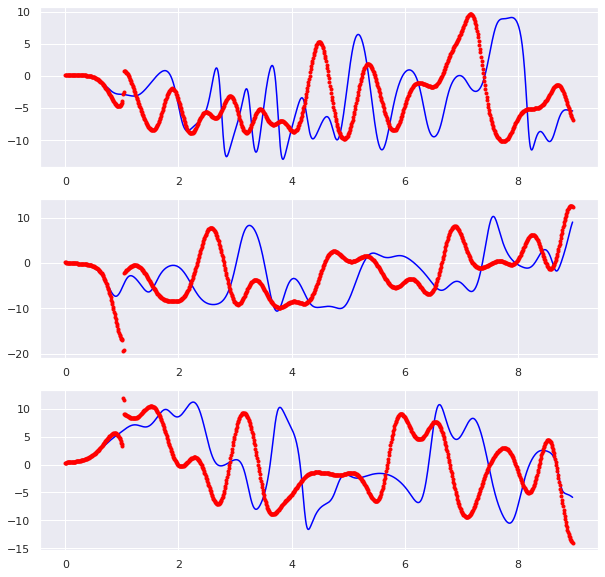

In [30]:
y_train_plot = np.matrix(y_train)
print('y_train_plot shape:',y_train_plot.shape)
Architope_prediction_y_train_plot = np.matrix(Architope_prediction_y_train)
print('Architope_prediction_y_train_plot shape:',Architope_prediction_y_train_plot.shape)
# spatial grid and initial conditions
h = 0.01

tmax = 8.98
step_max = round(tmax/h)
step_plt = int(tmax/(898*h))
dt = h
tt = 0

for step in range(1, step_max):
    t = step*h
    if step % step_plt == 0:
        tt = np.hstack((tt, t))

fig = plt.figure(figsize=(10,10))
N = 3
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    row = int(X1.shape[0]/float(N+1))*(i+1)
    print(row)
    print(np.array(y_train_plot[:,row]).shape,Architope_prediction_y_train_plot[:,row].shape)
    ax.plot(tt, np.real(y_train_plot[:,row]), color='blue')
    ax.plot(tt, np.real(Architope_prediction_y_train_plot[:,row]), '.', color='red')


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


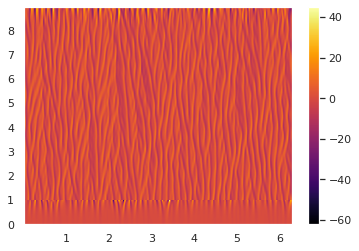

x shape: (898, 2048)
tt shape: (898, 2048)
uu shape: (898, 2048)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.matrix'>


In [31]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

N = 2048
x = (2*np.pi*np.arange(1,N+1)/N)

fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, tt)
uu_mks = np.matrix(Architope_prediction_y_train_plot)
im = ax.pcolormesh(X, T, np.real(uu_mks), cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()
print('x shape:', X.shape)
print('tt shape:', T.shape)
print('uu shape:', uu_mks.shape)
print(type(X), type(T), type(uu_mks))

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


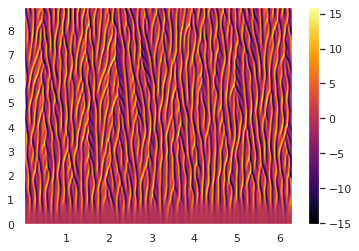

In [32]:
fig, ax = plt.subplots(1,1)
uu_ks = np.matrix(y_train_plot)
im = ax.pcolormesh(X, T, np.real(uu_ks), cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

In [33]:
#print(Architope_prediction_y_train_plot[:,row])

#### Write Predictions

Compute Performance

In [34]:
#y_test_in = y_test[:,jj]
#print(y_test[:,jj].shape,y_test_in.shape)

In [35]:
# Compute Peformance
print('y_train shape:',y_train.shape)
print('Architope_prediction_y_train shape:', Architope_prediction_y_train.shape)
print('y_test shape:',y_test.shape)
print('Architope_prediction_y_test shape:', Architope_prediction_y_test.shape)
performance_Architope_C = np.zeros((3,3))
for jj in range(3):
    performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train[:,jj],
                                    y_test_hat_in=Architope_prediction_y_test[:,jj],
                                    y_train_in=y_train[:,jj],
                                    y_test_in=y_test[:,jj])
    # Update User
    print('dimension:',jj,performance_Architope)
    #performance_Architope = np.sum(performance_Architope_C, axis=1)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))


y_train shape: (898, 2048)
Architope_prediction_y_train shape: (898, 2048)
y_test shape: (100, 2048)


NameError: name 'Architope_prediction_y_test' is not defined

## Notes for the user update reported above
- dimension 0 corrispond to the x dimension
- dimension 1 corrispond to the y dimension
- dimension 2 corrispond to the z dimension

---

---

---

## Save data

In [ ]:
import pandas as pd

print(xd_star.shape)
print(yd_star.shape)
print(zd_star.shape)
row = np.array(['xdot', 'ydot', 'zdot']).T
row_n = row.shape[0] ##last row
Xdot_lorenz_outputPCNN_dataframe = pd.DataFrame(Architope_prediction_y_train_plot, columns=['xdot', 'ydot', 'zdot'])
Xdot_lorenz_outputPCNN_dataframe.index.names = ['index']
Xdot_lorenz_outputPCNN_dataframe.to_csv('lorenz_PCNN_train.csv')
np.savetxt("lorenz_PCNN_train.csv", Xdot_lorenz_outputPCNN_dataframe, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)

#########################################################
Xdot_lorenz_outputPCNN_dataframe_test = pd.DataFrame(Architope_prediction_y_test_plot, columns=['xdot', 'ydot', 'zdot'])
Xdot_lorenz_outputPCNN_dataframe_test.index.names = ['index']
Xdot_lorenz_outputPCNN_dataframe_test.to_csv('lorenz_PCNN_test.csv')
np.savetxt("lorenz_PCNN_test.csv", Xdot_lorenz_outputPCNN_dataframe_test, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)
 
# print dataframes.
Xdot_lorenz_outputPCNN_dataframe
#########################################################
############## -- save data manifold -- #################
#########################################################
print('Architope_manifolds_prediction_y_train',Architope_manifolds_prediction_y_train.shape)
print('Architope_manifolds_prediction_y_test',Architope_manifolds_prediction_y_test.shape)
################ --- manifold 1 train --- #####################
Architope_manifold1_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,0], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold1_prediction_y_train.index.names = ['index']
Architope_manifold1_prediction_y_train.to_csv('lorenz_PCNN_manifold1.csv')
np.savetxt("lorenz_PCNN_manifold1.csv", Architope_manifold1_prediction_y_train, delimiter=",")
################ --- manifold 2 train --- #####################
Architope_manifold2_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,1], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold2_prediction_y_train.index.names = ['index']
Architope_manifold2_prediction_y_train.to_csv('lorenz_PCNN_manifold2.csv')
np.savetxt("lorenz_PCNN_manifold2.csv", Architope_manifold2_prediction_y_train, delimiter=",")
################ --- manifold 3 train --- #####################
#Architope_manifold3_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_train.index.names = ['index']
#Architope_manifold3_prediction_y_train.to_csv('lorenz_PCNN_manifold3.csv')
#np.savetxt("lorenz_PCNN_manifold3.csv", Architope_manifold3_prediction_y_train, delimiter=",")

################ --- manifold 1 test --- #####################
Architope_manifold1_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,0], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold1_prediction_y_test.index.names = ['index']
Architope_manifold1_prediction_y_test.to_csv('lorenz_PCNN_manifold1_test.csv')
np.savetxt("lorenz_PCNN_manifold1_test.csv", Architope_manifold1_prediction_y_test, delimiter=",")
################ --- manifold 2 test --- #####################
Architope_manifold2_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,1], columns=['xdot', 'ydot', 'zdot'])
Architope_manifold2_prediction_y_test.index.names = ['index']
Architope_manifold2_prediction_y_test.to_csv('lorenz_PCNN_manifold2_test.csv')
np.savetxt("lorenz_PCNN_manifold2_test.csv", Architope_manifold2_prediction_y_test, delimiter=",")
################ --- manifold 3 test --- #####################
#Architope_manifold3_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_test.index.names = ['index']
#Architope_manifold3_prediction_y_test.to_csv('lorenz_PCNN_manifold3_test.csv')
#np.savetxt("lorenz_PCNN_manifold3_test.csv", Architope_manifold3_prediction_y_test, delimiter=",")


### Model Complexity/Efficiency Metrics

In [ ]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [ ]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [ ]:
parameters = {'penalty': ['none','l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [ ]:
# Update User on shape of learned partition
print(partition_labels_training)

In [ ]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

#### Write Predicted Class(es)

In [ ]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [ ]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [ ]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

---
## Bagged Feed-Forward Networks (ffNNs)

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [ ]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [ ]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

In [ ]:
print("Random Partition: Generated!...Feature Generation Complete!")

## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [ ]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

In [ ]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [ ]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                      n_jobs = n_jobs, 
                                                                                      n_iter = n_iter, 
                                                                                      param_grid_in = param_grid_Vanilla_Nets, 
                                                                                      X_train=X_train, 
                                                                                      y_train=data_y, 
                                                                                      X_test_partial=X_train,
                                                                                      X_test=X_test,
                                                                                      NOCV=True)

In [ ]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [ ]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

#### Evaluate Performance

In [ ]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

#### Compute Required Training Time(s)

In [ ]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

## Run: Gradient Boosted Random Forest Regression

In [ ]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

## Training Result(s)
#### (Update) Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [ ]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

### Model Complexity/Efficiency Metrics

In [ ]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

# Summary

In [ ]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='slategrey',label=r'$f_1(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)
#
#jj = 0
#for j in range(0,len(x)-1,10):
#    jj = jj+1;
#    plt.scatter(x[j],y_hat_train_Vanilla_ffNN[jj], color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
#    plt.scatter(x[j],Architope_prediction_y_train[jj], color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

In [ ]:
#import numpy as np
#print(len(x)-1,len(y_hat_train_Vanilla_ffNN))
#print(np.linspace(10,len(x)-1,len(y_hat_train_Vanilla_ffNN)))
#def my_func(low,up,leng):
#    list = []
#    step = int((up - low) / float(leng))
#    print(step)
#    for i in range(leng):
#        list.append(int(low))
#        low = int(low + step)
#    return list
#
#my_list = my_func(0,len(x)-1,len(y_hat_train_Vanilla_ffNN))
#res = [int(item) for item in my_list]
#
#print(my_list)
#print(type(my_list))
#
#indice_prova = 10,len(x)-1,len(y_hat_train_Vanilla_ffNN);
#for j in range(0,len(x)-1,10):
#    print(j,np.matrix(x[j]).shape)
    

---
# Fin
---

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
dfX_train = pd.DataFrame(X_train,columns=['x','y','z'])
dfX_train.plot(x = 'x', y='y', z='z', kind = 'scatter')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/lorenz.pdf', format='pdf')